In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
# Load Boston Housing dataset
boston = fetch_openml(name='boston'
                      , version=1
                      , as_frame=True
                     )
X = boston.data
y = boston.target

print(X.shape, y.shape)

(506, 13) (506,)


In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y
    , test_size=0.2
    , random_state=27
)

In [7]:
# Scale the data!!!
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# ElasticNet model
elastic_net = ElasticNet(
    random_state=27
)

In [17]:
# Hyperparameter grid
# alphas = np.logspace(-3, 2, 20)
# l1_ratios = np.linspace(0.1, 1.0, 10)

# Clean, rounded hyperparams for better viz
alphas = np.round(np.logspace(-3, 2, 20), 6)
l1_ratios = np.round(np.linspace(0.1, 1, 10), 2)

param_grid = {
    'alpha': alphas
    , 'l1_ratio': l1_ratios
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=elastic_net
    , param_grid=param_grid
    , scoring='neg_mean_squared_error'
    , cv=5
)

In [10]:
# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_model

ElasticNet(alpha=0.037927, l1_ratio=0.1, random_state=27)

In [11]:
best_params

{'alpha': 0.037927, 'l1_ratio': 0.1}

In [12]:
# Predictions
y_pred = best_model.predict(X_test)

In [13]:
# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmse_ratio = rmse / np.mean(y_test)

In [14]:
metrics_summary = {
    'MAR': mae
    , 'RMSE': rmse
    , 'R² Score': r2
    , 'RMSE Ratio': rmse_ratio
}
metrics_summary

{'MAR': 3.516478936808583,
 'RMSE': 5.25314588947901,
 'R² Score': 0.6954208009651397,
 'RMSE Ratio': 0.23318865032938427}

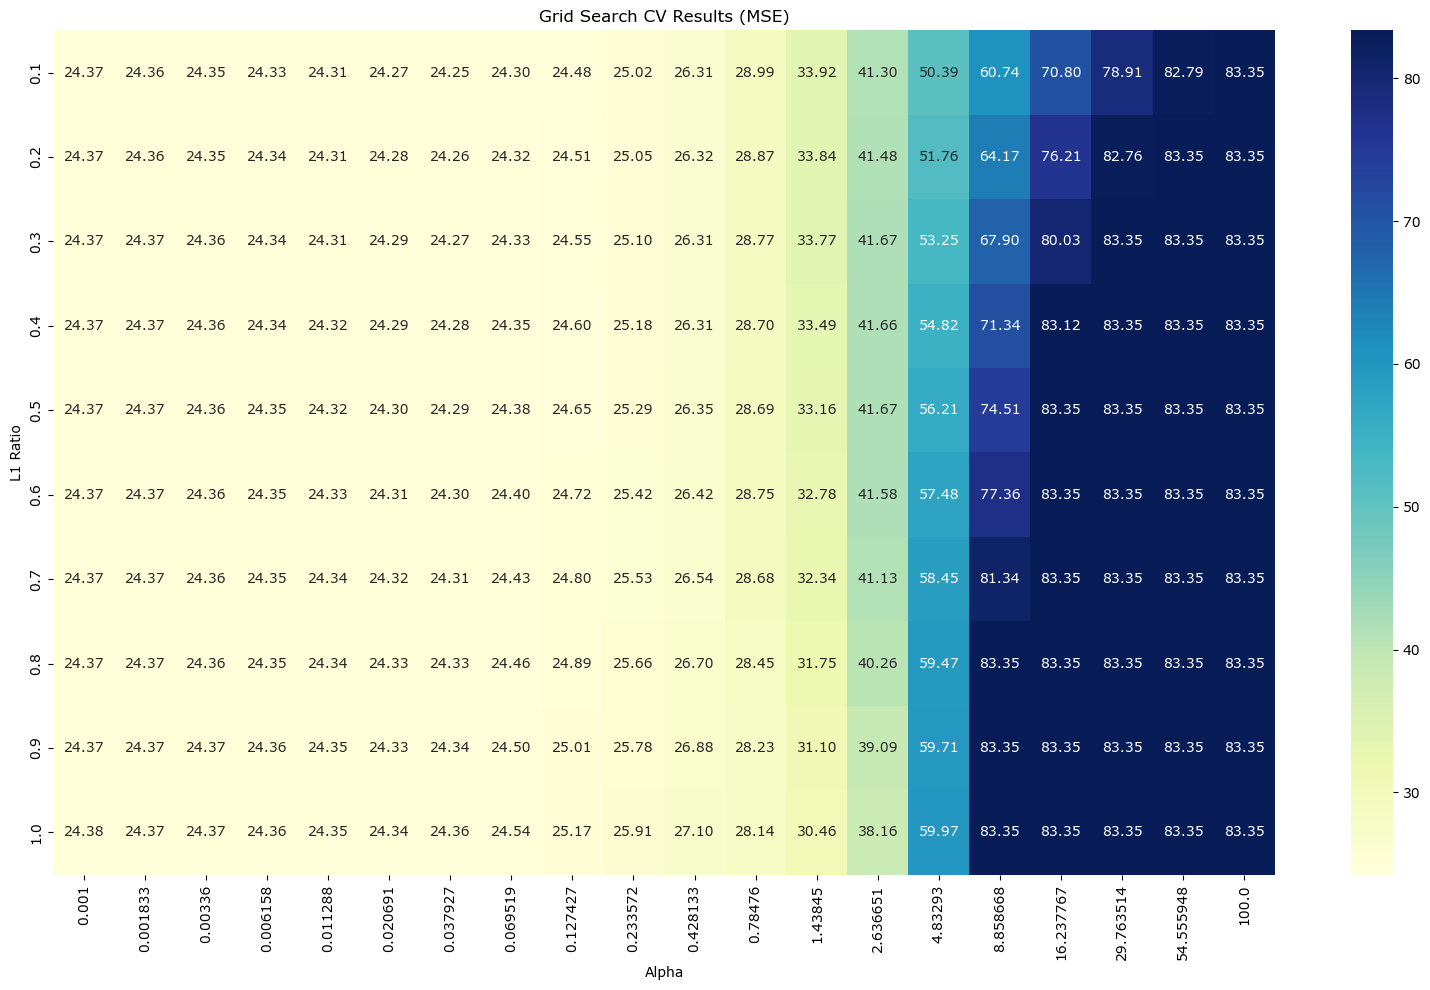

In [15]:
# Convert grid results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot table for heatmap
heatmap_data = results_df.pivot_table(
    index='param_l1_ratio'
    , columns='param_alpha'
    , values='mean_test_score')

# Convert scores from negative MSE to positive
heatmap_data = -1 * heatmap_data

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data
    , annot=True
    , fmt=".2f"
    , cmap="YlGnBu"
)
plt.title("Grid Search CV Results (MSE)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


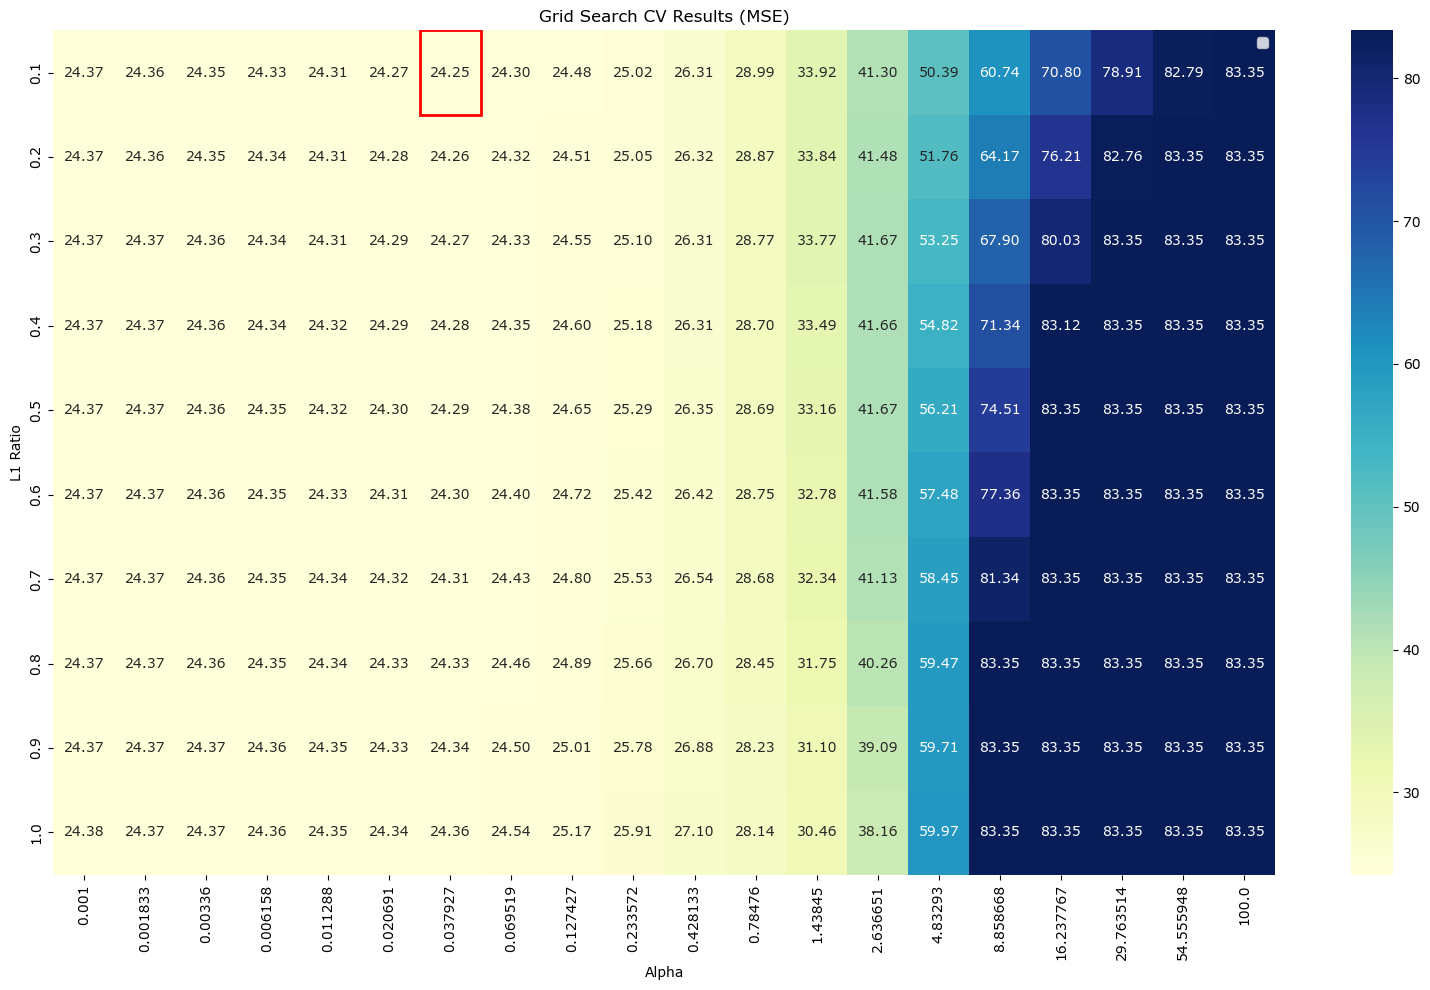

In [16]:
# UPDATE: Heatmap w/ best MSE marked by red box;

# Convert cv results to DataFrame
results_df = pd.DataFrame(
    grid_search.cv_results_)

# Pivot table for heatmap
heatmap_mse = results_df.pivot_table(
    index='param_l1_ratio'
    , columns='param_alpha'
    , values='mean_test_score')

# Convert from negative MSE to positive
heatmap_mse = -1 * heatmap_mse

# Identify the location of the best score (lowest MSE)
best_idx_mse = np.unravel_index(
    np.argmin(heatmap_mse.values)
    , heatmap_mse.shape)

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(heatmap_mse  
            , annot=True, fmt=".2f"
            , cmap="YlGnBu", ax=ax)

# Draw rectangle around best-performing cell
import matplotlib.patches as patches

highlight_rect = patches.Rectangle(
    (best_idx_mse[1], best_idx_mse[0])  # x, y
    , 1, 1, fill=False         # width, height
    , edgecolor='red'
    , linewidth=2)

ax.add_patch(highlight_rect)

plt.title("Grid Search CV Results (MSE)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show();

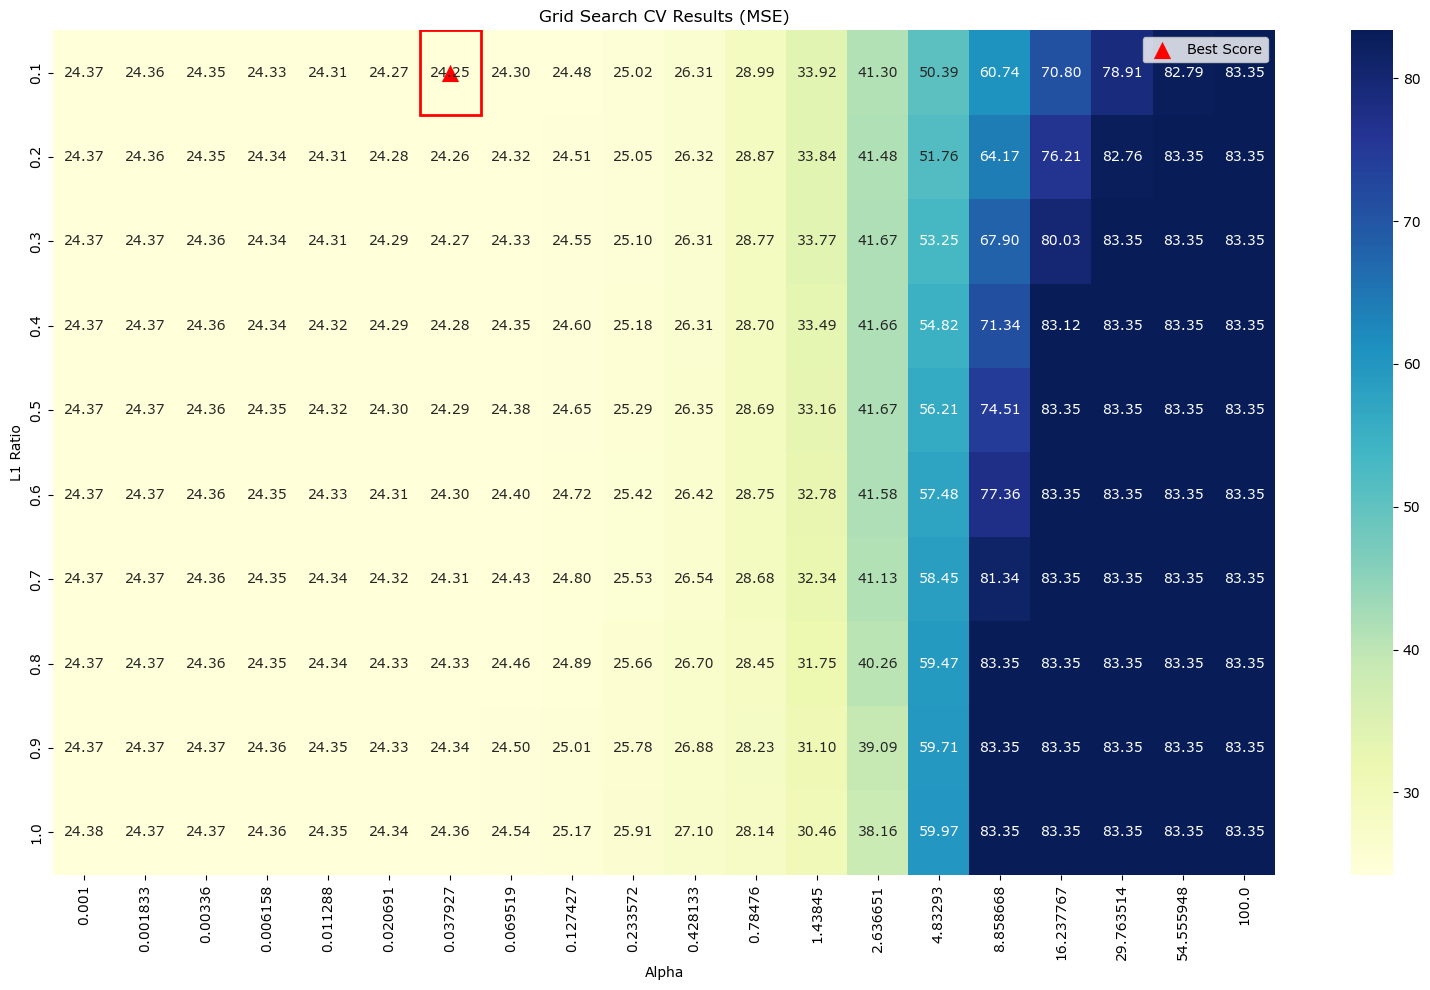

In [23]:
# Convert cv results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot table for heatmap
heatmap_mse = results_df.pivot_table(
    index='param_l1_ratio'
    , columns='param_alpha'
    , values='mean_test_score'
)

# Convert from negative MSE to positive
heatmap_mse = -1 * heatmap_mse

# Identify the location of the best score (lowest MSE)
best_idx_mse = np.unravel_index(np.argmin(heatmap_mse.values), heatmap_mse.shape)

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(
    heatmap_mse
    , annot=True
    , fmt=".2f"
    , cmap="YlGnBu"
    , ax=ax
)

# Draw rectangle around best-performing cell
import matplotlib.patches as patches

highlight_rect = patches.Rectangle(
    (best_idx_mse[1], best_idx_mse[0])  # x, y
    , 1, 1                              # width, height
    , fill=False
    , edgecolor='red'
    , linewidth=2
)
ax.add_patch(highlight_rect)

# Optional: add a marker too
ax.scatter(
    best_idx_mse[1] + 0.5
    , best_idx_mse[0] + 0.5
    , s=150
    , c='red'
    , marker='^'
    , edgecolors='red'
    , linewidths=0.1
    , label='Best Score'
)

plt.title("Grid Search CV Results (MSE)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


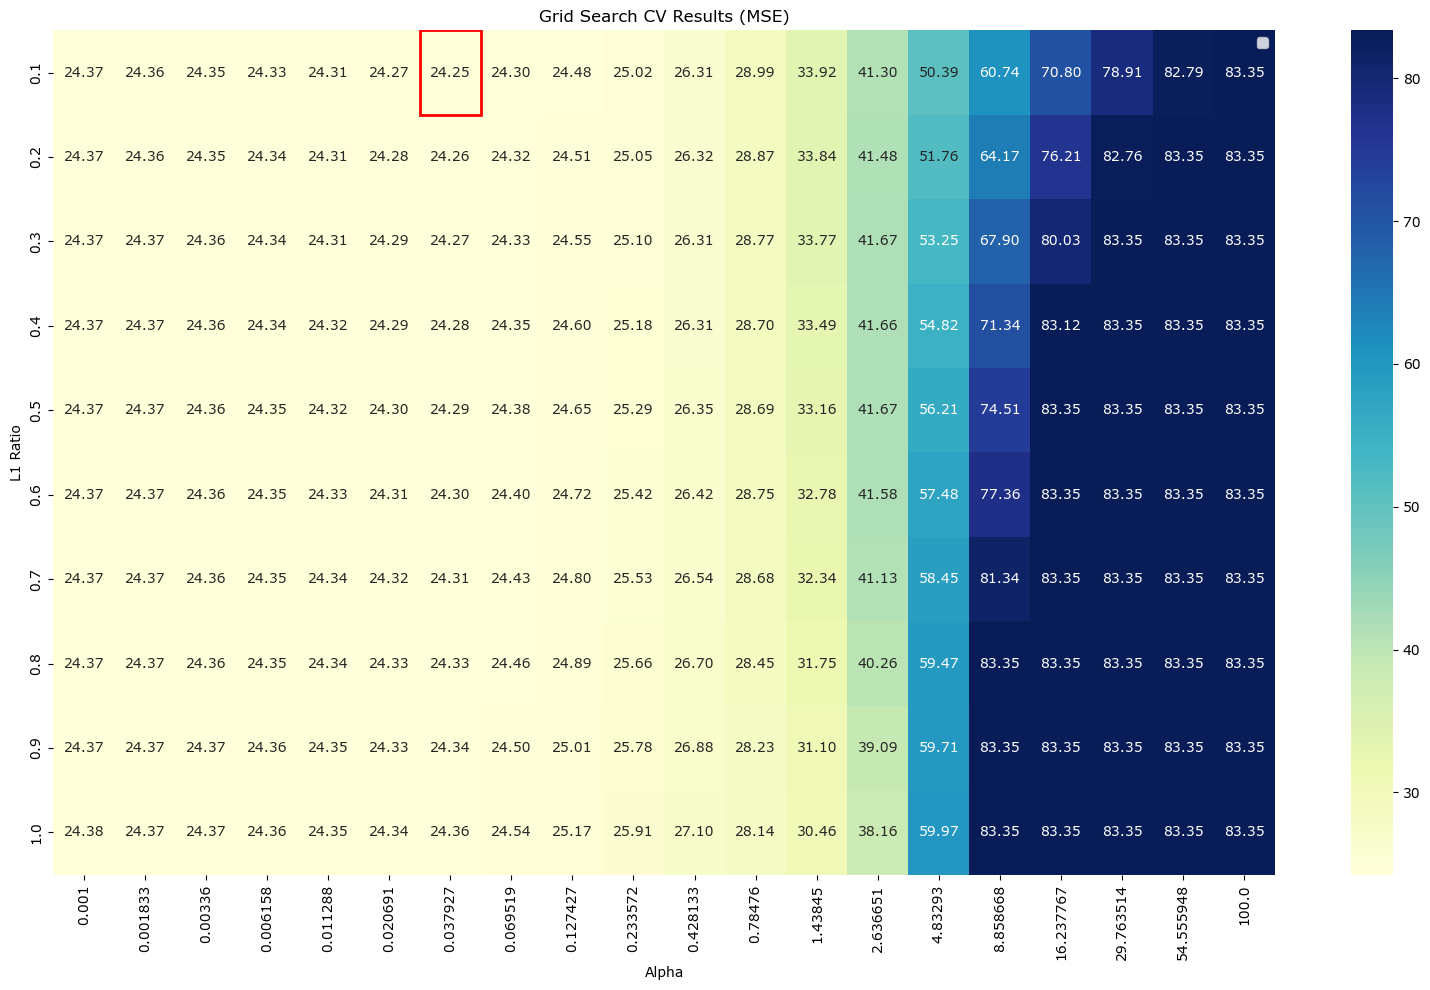

In [29]:
# Convert cv results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot table for heatmap
heatmap_mse = results_df.pivot_table(
    index='param_l1_ratio'
    , columns='param_alpha'
    , values='mean_test_score'
)

# Convert from negative MSE to positive
heatmap_mse = -1 * heatmap_mse

# Identify the location of the best score (lowest MSE)
best_idx_mse = np.unravel_index(np.argmin(heatmap_mse.values), heatmap_mse.shape)

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(
    heatmap_mse
    , annot=True
    , fmt=".2f"
    , cmap="YlGnBu"
    , ax=ax
)

# Draw rectangle around best-performing cell
import matplotlib.patches as patches

highlight_rect = patches.Rectangle(
    (best_idx_mse[1], best_idx_mse[0])  # x, y
    , 1, 1                              # width, height
    , fill=False
    , edgecolor='red'
    , linewidth=2
)
ax.add_patch(highlight_rect)

plt.title("Grid Search CV Results (MSE)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show();

NameError: name 'best_idx' is not defined

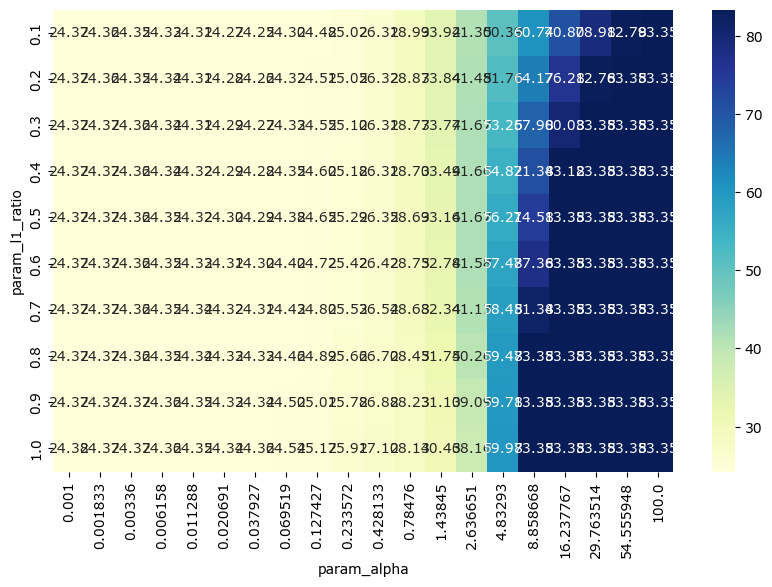

In [16]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    heatmap_mse
    , annot=True
    , fmt=".2f"
    , cmap="YlGnBu"
    , ax=ax
)

# Rectangle around best cell
rect = patches.Rectangle(
    (best_idx[1], best_idx[0])  # (x, y)
    , 1, 1                      # width, height of one cell
    , fill=False
    , edgecolor='cyan'
    , linewidth=3
)
ax.add_patch(rect)

plt.title("Grid Search CV Results (RMSE Ratio)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()

In [28]:
np.round(np.logspace(-3, 2, 20), 6)

array([1.0000000e-03, 1.8330000e-03, 3.3600000e-03, 6.1580000e-03,
       1.1288000e-02, 2.0691000e-02, 3.7927000e-02, 6.9519000e-02,
       1.2742700e-01, 2.3357200e-01, 4.2813300e-01, 7.8476000e-01,
       1.4384500e+00, 2.6366510e+00, 4.8329300e+00, 8.8586680e+00,
       1.6237767e+01, 2.9763514e+01, 5.4555948e+01, 1.0000000e+02])

In [ ]:
log_numbers = np.logspace(-3, 2, 20)

# Correct way to format the array
formatted_numbers = np.vectorize(lambda x: np.format_float_positional(x, precision=4))(log_numbers)
formatted_numbers

In [12]:
np.vectorize(lambda x: np.format_float_positional(x, precision=4))(np.logspace(-3, 2, 20))
formatted_numbers

array(['0.001', '0.0018', '0.0034', '0.0062', '0.0113', '0.0207',
       '0.0379', '0.0695', '0.1274', '0.2336', '0.4281', '0.7848',
       '1.4384', '2.6367', '4.8329', '8.8587', '16.2378', '29.7635',
       '54.5559', '100.'], dtype='<U7')

In [17]:
np.round(np.logspace(-3, 2, 20), decimals=4)

array([1.00000e-03, 1.80000e-03, 3.40000e-03, 6.20000e-03, 1.13000e-02,
       2.07000e-02, 3.79000e-02, 6.95000e-02, 1.27400e-01, 2.33600e-01,
       4.28100e-01, 7.84800e-01, 1.43840e+00, 2.63670e+00, 4.83290e+00,
       8.85870e+00, 1.62378e+01, 2.97635e+01, 5.45559e+01, 1.00000e+02])

In [19]:
np.logspace(-3, 2, 20).round(4)

array([1.00000e-03, 1.80000e-03, 3.40000e-03, 6.20000e-03, 1.13000e-02,
       2.07000e-02, 3.79000e-02, 6.95000e-02, 1.27400e-01, 2.33600e-01,
       4.28100e-01, 7.84800e-01, 1.43840e+00, 2.63670e+00, 4.83290e+00,
       8.85870e+00, 1.62378e+01, 2.97635e+01, 5.45559e+01, 1.00000e+02])

In [19]:
# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data
    , annot=True
    , fmt=".2f"
    , cmap="Magma"
    #, cmap="Viridis"
)
plt.title("Grid Search CV Results (MSE)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()

KeyError: "'Magma' is not a known colormap name"

<Figure size 1600x1000 with 0 Axes>

In [16]:
print(np.around(alphas, 4))

[1.00000e-03 1.80000e-03 3.40000e-03 6.20000e-03 1.13000e-02 2.07000e-02
 3.79000e-02 6.95000e-02 1.27400e-01 2.33600e-01 4.28100e-01 7.84800e-01
 1.43840e+00 2.63670e+00 4.83290e+00 8.85870e+00 1.62378e+01 2.97635e+01
 5.45559e+01 1.00000e+02]


In [17]:
print(alphas)

[1.0000000e-03 1.8330000e-03 3.3600000e-03 6.1580000e-03 1.1288000e-02
 2.0691000e-02 3.7927000e-02 6.9519000e-02 1.2742700e-01 2.3357200e-01
 4.2813300e-01 7.8476000e-01 1.4384500e+00 2.6366510e+00 4.8329300e+00
 8.8586680e+00 1.6237767e+01 2.9763514e+01 5.4555948e+01 1.0000000e+02]


In [12]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmse_ratio(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

rmse_scorer = make_scorer(rmse, greater_is_better=False)
rmse_ratio_scorer = make_scorer(rmse_ratio, greater_is_better=False)

In [13]:
grid_search_custom = GridSearchCV(
    estimator=elastic_net
    , param_grid=param_grid
    , scoring=rmse_ratio_scorer  # or rmse_scorer
    , cv=5
    , n_jobs=-1
    , return_train_score=True
)

grid_search_custom.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=27), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             return_train_score=True,
             scoring=make_scorer(rmse_ratio, greater_is_better=False))

In [15]:
# Best model
best_model_cust = grid_search_custom.best_estimator_
best_params_cust = grid_search_custom.best_params_

best_model_cust

ElasticNet(alpha=0.046415888336127795, l1_ratio=0.1, random_state=27)

In [16]:
best_params_cust

{'alpha': 0.046415888336127795, 'l1_ratio': 0.1}

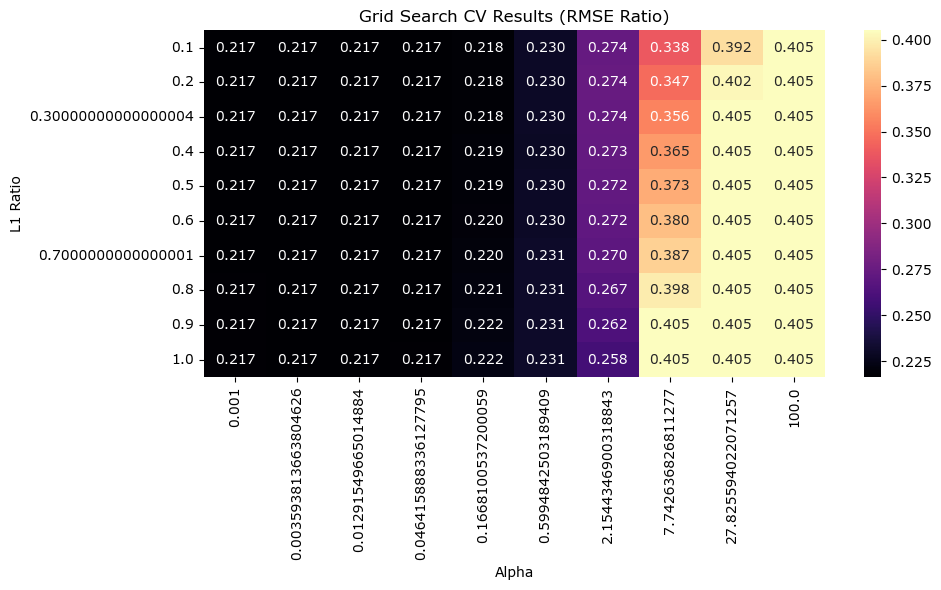

In [14]:
# DataFrame of results
results_custom = pd.DataFrame(grid_search_custom.cv_results_)

# Pivot and convert to positive values
heatmap_custom = results_custom.pivot_table(
    index='param_l1_ratio'
    , columns='param_alpha'
    , values='mean_test_score'
)

# Since RMSE and RMSE ratio scorers were negated (greater_is_better=False)
heatmap_custom = -1 * heatmap_custom

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_custom
    , annot=True
    , fmt=".3f"
    , cmap="magma"
)
plt.title("Grid Search CV Results (RMSE Ratio)")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()

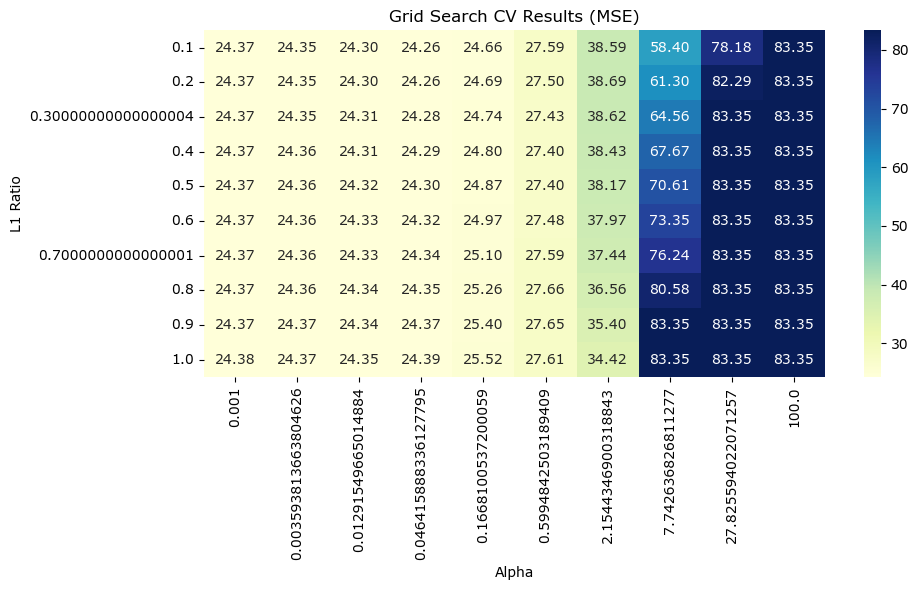